In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv('spx_opt_prepared.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [40]:
df.head()

,Ask,Bid,Implied.Volatility,quote,exp,T,option_type,strike,underlying,midprice,fwd_price,forward_moneyness,interest_rate
0,217.9,215.4,12.2624,2023-09-05,2024-01-19,136,p,4725,4496.83,216.65,4571.761037,1.033519,0.013662
1,239.6,236.6,12.3617,2023-09-06,2024-01-19,135,p,4725,4465.48,238.10,4539.815035,1.040791,0.013732
2,248.1,244.6,12.1843,2023-09-07,2024-01-19,134,p,4725,4451.14,246.35,4524.538599,1.044305,0.013859
3,239.9,236.3,11.7455,2023-09-08,2024-01-19,133,p,4725,4457.49,238.10,4530.774105,1.042868,0.013724
4,221.1,218.8,11.8312,2023-09-11,2024-01-19,130,p,4725,4487.46,219.95,4558.788148,1.036460,0.013572


In [42]:

df_calls = df[df['option_type'] == 'c'].copy()
df_puts = df[df['option_type'] == 'p'].copy()

df_calls = df_calls.rename(columns={
    'Ask': 'Call_Ask',
    'Bid': 'Call_Bid',
    'midprice': 'Call_Midprice'
})

df_puts = df_puts.rename(columns={
    'Ask': 'Put_Ask',
    'Bid': 'Put_Bid',
    'midprice': 'Put_Midprice'
})[['strike', 'exp', 'quote', 'T', 'underlying', 'Put_Ask', 'Put_Bid', 'Put_Midprice']]

df_merged = pd.merge(df_calls, df_puts, on=['strike', 'exp', 'quote', 'T', 'underlying'], how='inner')


In [43]:
df_merged

,Call_Ask,Call_Bid,Implied.Volatility,quote,exp,T,option_type,strike,underlying,Call_Midprice,fwd_price,forward_moneyness,interest_rate,Put_Ask,Put_Bid,Put_Midprice
0,398.50,395.10,16.3645,2023-09-05,2023-12-15,101,c,4190,4496.83,396.800,4552.000000,0.920475,0.016595,41.2,40.6,40.90
1,371.40,368.50,16.3036,2023-09-06,2023-12-15,100,c,4190,4465.48,369.950,4520.500000,0.926889,0.016859,46.6,46.1,46.35
2,359.60,356.40,16.7593,2023-09-07,2023-12-15,99,c,4190,4451.14,358.000,4505.250000,0.930026,0.016784,47.7,47.0,47.35
3,364.40,360.80,16.9224,2023-09-08,2023-12-15,98,c,4190,4457.49,362.600,4511.250000,0.928789,0.017114,43.3,42.7,43.00
4,382.90,380.00,16.5400,2023-09-11,2023-12-15,95,c,4190,4487.46,381.450,4539.500000,0.923009,0.017582,38.0,37.3,37.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47252,2.70,2.45,11.4067,2023-09-25,2024-01-19,116,c,5000,4337.44,2.575,4397.224000,1.137081,0.014478,599.1,580.0,589.55
47253,2.25,2.10,12.3261,2023-09-26,2024-01-19,115,c,5000,4273.53,2.175,4333.172778,1.153889,0.014675,660.6,639.8,650.20
47254,2.25,2.05,12.2796,2023-09-27,2024-01-19,114,c,5000,4274.51,2.150,4331.708328,1.154279,0.014845,659.7,641.7,650.70
47255,2.40,2.25,12.1208,2023-09-28,2024-01-19,113,c,5000,4299.70,2.325,4355.553856,1.147960,0.014874,633.6,629.6,631.60


In [15]:
import statsmodels.api as sm

In [45]:
# Initialize a list to store the results
results_list = []

# Group by 'exp' (expiration date) and 'quote' date
group_cols = ['exp', 'quote']

# Process each group separately
for (exp_date, quote_date), group in df_merged.groupby(group_cols):

    # Get the spot price S (underlying price) at this quote date
    S = group['underlying'].iloc[0]

    # Determine ATM price as S
    ATM_price = S

    # Define the strike range: ATM - 8% to ATM + 8%
    lower_strike = ATM_price * 0.92
    upper_strike = ATM_price * 1.08

    # Select options within this strike range
    group_selected = group[(group['strike'] >= lower_strike) & (group['strike'] <= upper_strike)]

    # Ensure that midprices are available
    group_selected = group_selected.dropna(subset=['Call_Midprice', 'Put_Midprice'])

    if len(group_selected) < 2:
        # Not enough data points to perform regression
        continue
    
    Xi = group_selected['strike']
    Yi = group_selected['Call_Midprice'] - group_selected['Put_Midprice'] - S
    
    X_with_const = sm.add_constant(Xi)

    # Perform Ordinary Least Squares regression
    model = sm.OLS(Yi, X_with_const)
    results = model.fit()

    # Extract regression coefficients
    alpha = results.params['const']
    beta = results.params['strike']
    
    DF = -beta
    Div = -alpha
    F = (S - Div) / DF

    result = {
        'exp': exp_date,
        'quote': quote_date,
        'Spot_Price': S,
        'DF': DF,
        'Div': Div,
        'Forward_Price': F
    }
    results_list.append(result)

# Create a dataframe with the results
df_results = pd.DataFrame(results_list)
df_results.head()

,exp,quote,Spot_Price,DF,Div,Forward_Price
0,2023-09-15,2023-09-05,4496.83,0.997796,4.633556,4502.120079
1,2023-09-15,2023-09-06,4465.48,0.998125,4.291036,4469.569407
2,2023-09-15,2023-09-07,4451.14,0.998799,-0.146127,4456.636480
3,2023-09-15,2023-09-08,4457.49,0.999219,-4.344775,4465.320542
4,2023-09-15,2023-09-11,4487.46,0.998956,2.229333,4489.917454


In [46]:
df_merged = pd.merge(df_merged, df_results[['exp', 'quote', 'DF', 'Div', 'Forward_Price']], on=['exp', 'quote'], how='left')


In [48]:
df_merged['impl_ir'] = -np.log(df_merged['DF']) / (df_merged['T'] / 365)

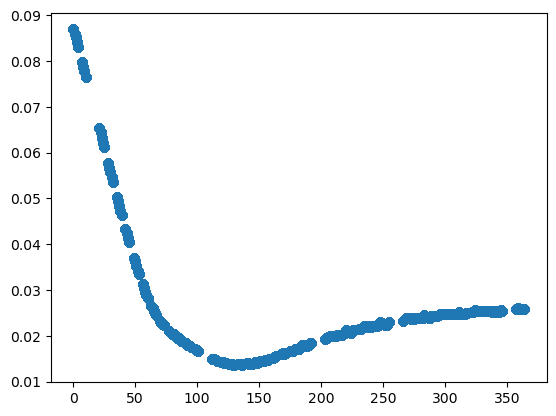

In [ ]:
plt.scatter(df_merged['T'], df_merged['interest_rate'])
plt.show()

In [60]:
quote_date = '2023-09-05'
df_expiry = df[(df['exp'] == '2023-12-15') & (df['quote'] == quote_date)].copy()

In [64]:
df_calls = df_expiry[df_expiry['option_type'] == 'c'].copy()
df_calls.sort_values('strike', inplace=True)

In [165]:
from scipy.interpolate import interp1d, UnivariateSpline, LSQUnivariateSpline

strikes = df_calls['strike'].values
call_prices = df_calls['midprice'].values

smoothing_factor = 0.35
spline = UnivariateSpline(strikes, call_prices, k=3, s=smoothing_factor)
#knot_positions = np.linspace(strikes.min(), strikes.max(), 60)
#spline = LSQUnivariateSpline(strikes, call_prices, t=knot_positions[1:-1], k=3)


strike_min = strikes.min()
strike_max = strikes.max()
strike_range = np.linspace(strike_min, strike_max, 2000)

density = spline.derivative(n=2)(strike_range)
density = np.maximum(density, 0)

area = np.trapz(density, strike_range)
density_normalized = density / area

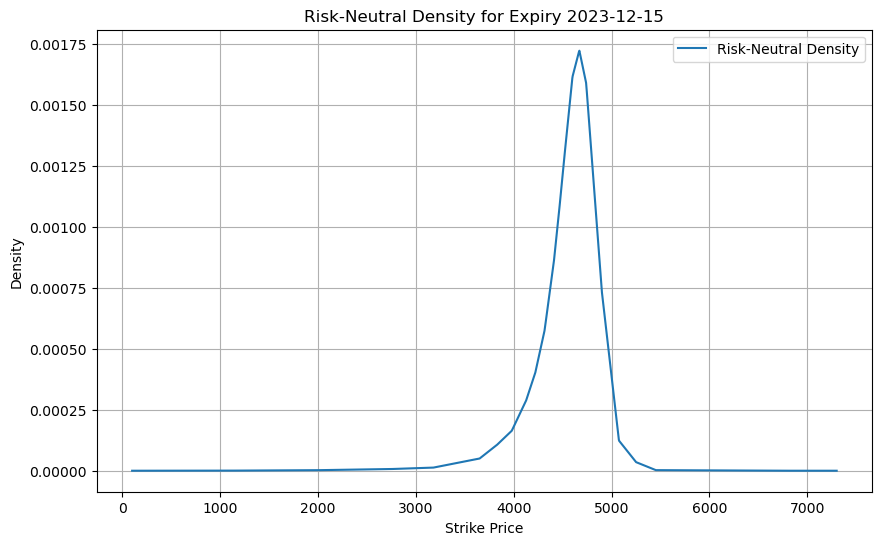

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(strike_range, density, label='Risk-Neutral Density')
#sns.kdeplot(strikes, label='Risk-Neutral Density', color='blue')
plt.xlabel('Strike Price')
plt.ylabel('Density')
plt.title('Risk-Neutral Density for Expiry {}'.format('2023-12-15'))
plt.legend()
plt.grid(True)
plt.show()

In [173]:
# Define the interval for the payoff (4000 to 4200)
lower_bound = 4500
upper_bound = 4700

# Extract the portion of the RND within the interval [4000, 4200]
mask = np.logical_and(strike_range >= lower_bound, strike_range <= upper_bound)
density_within_interval = density_normalized[mask]
strike_within_interval = strike_range[mask]

# Integrate the RND over the interval [4000, 4200]
contract_price = np.trapz(density_within_interval, strike_within_interval)

# Display the result
print(f"The price of the contract is: ${contract_price:.4f}")


The price of the contract is: $0.3115


array([False, False, False, ..., False, False, False])